# Nigerian Music scraped from Spotify - an analysis

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

0. LOAD AND FILTER DATA

In [15]:
print("Loading and filtering data...")
df = pd.read_csv("../../data/nigerian-songs.csv")
df = df[(df['artist_top_genre'].isin(['afro dancehall', 'afropop', 'nigerian pop'])) & (df['popularity'] > 0)]
print(f"Dataset shape: {df.shape} \n")
df.head()


Loading and filtering data...
Dataset shape: (286, 16) 



,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4
5,Kasala,Pioneers,DRB Lasgidi,nigerian pop,2020,184800,26,0.803,0.1270,0.525,0.000007,0.1290,-10.034,0.1970,100.103,4
6,Pull Up,Everything Pretty,prettyboydo,nigerian pop,2018,202648,29,0.818,0.4520,0.587,0.004490,0.5900,-9.840,0.1990,95.842,4


1. ENHANCED FEATURE ENGINEERING WITH POPULARITY FOCUS

In [16]:
print("\n======= ENHANCED FEATURE ENGINEERING =======")

# Basic audio features
audio_features = ['length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 
                 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']

# 1.1 Create popularity transformations
print("Generating popularity transformations...")
# Log-transform popularity to handle its potential non-linear effects
df['log_popularity'] = np.log1p(df['popularity'])
# Square-root transform popularity
df['sqrt_popularity'] = np.sqrt(df['popularity'])
# Create popularity bins/tiers
df['popularity_tier'] = pd.qcut(df['popularity'], q=3, labels=['low', 'medium', 'high'])
df['popularity_bin'] = pd.cut(df['popularity'], bins=[0, 25, 50, 75, 100], 
                        labels=['very_low', 'low', 'medium', 'high'])

# Create numeric versions of popularity bins for clustering
popularity_dummies = pd.get_dummies(df['popularity_tier'], prefix='pop_tier')
df = pd.concat([df, popularity_dummies], axis=1)

# 1.2 Create popularity-weighted features
print("Creating popularity-weighted features...")
for feature in ['danceability', 'energy', 'acousticness', 'tempo']:
    df[f'{feature}_pop_weighted'] = df[feature] * (df['popularity'] / 100)  # Normalizing popularity to 0-1 range

# 1.3 Create ratio and interaction features with popularity
df['energy_to_acousticness'] = df['energy'] / (df['acousticness'] + 0.01)  # Avoid division by zero
df['danceability_to_tempo'] = df['danceability'] / (df['tempo'] / 200)  # Normalize tempo
df['loudness_energy_product'] = df['loudness'] * df['energy']
df['speechiness_to_instrumentalness'] = df['speechiness'] / (df['instrumentalness'] + 0.01)

# New popularity-related interactions
df['pop_dance_product'] = df['popularity'] * df['danceability']
df['pop_energy_ratio'] = df['popularity'] / (df['energy'] * 100 + 0.01)  # Popularity per unit of energy
df['pop_tempo_ratio'] = df['popularity'] / (df['tempo'] + 0.01)  # Popularity per unit of tempo

# 1.4 Feature sets
# Original features
features_original = df[audio_features].copy()

# Extended features (original approach)
extended_features = audio_features + ['energy_to_acousticness', 'danceability_to_tempo', 
                                    'loudness_energy_product', 'speechiness_to_instrumentalness']
features_extended = df[extended_features].copy()

# New popularity-focused features
popularity_features = [
    'popularity', 'log_popularity', 'sqrt_popularity', 
    'danceability_pop_weighted', 'energy_pop_weighted', 'acousticness_pop_weighted', 'tempo_pop_weighted',
    'pop_dance_product', 'pop_energy_ratio', 'pop_tempo_ratio',
    'pop_tier_low', 'pop_tier_medium', 'pop_tier_high'
]
popularity_extended_features = extended_features + [f for f in popularity_features 
                                                  if f not in extended_features]
features_pop_extended = df[popularity_extended_features].copy()



======= ENHANCED FEATURE ENGINEERING =======
Generating popularity transformations...
Creating popularity-weighted features...


2. ADVANCED PREPROCESSING

In [17]:
print("\n======= ADVANCED PREPROCESSING =======")

# 2.1 Try different scalers
print("Testing different scaling methods...")
scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

X_scaled_dict = {}
for scaler_name, scaler in scalers.items():
    X_scaled_dict[f'original_{scaler_name}'] = scaler.fit_transform(features_original)
    X_scaled_dict[f'extended_{scaler_name}'] = scaler.fit_transform(features_extended)
    X_scaled_dict[f'pop_extended_{scaler_name}'] = scaler.fit_transform(features_pop_extended)

# Use standard scaling for main analysis
X_original_scaled = X_scaled_dict['original_standard']
X_extended_scaled = X_scaled_dict['extended_standard']
X_pop_extended_scaled = X_scaled_dict['pop_extended_standard']

# Encode genres for evaluation
le = LabelEncoder()
true_labels = le.fit_transform(df['artist_top_genre'])



======= ADVANCED PREPROCESSING =======
Testing different scaling methods...


3. FEATURE SELECTION USING MUTUAL INFORMATION


======= FEATURE SELECTION =======
Selecting most informative features based on mutual information...
Top 10 features for predicting popularity:
                      Feature     Score
1                  popularity  3.827336
16            sqrt_popularity  3.748795
15             log_popularity  3.676475
20         tempo_pop_weighted  1.740279
17  danceability_pop_weighted  1.737415
21          pop_dance_product  1.737415
23            pop_tempo_ratio  1.726988
22           pop_energy_ratio  1.610877
18        energy_pop_weighted  1.477963
26              pop_tier_high  0.640612


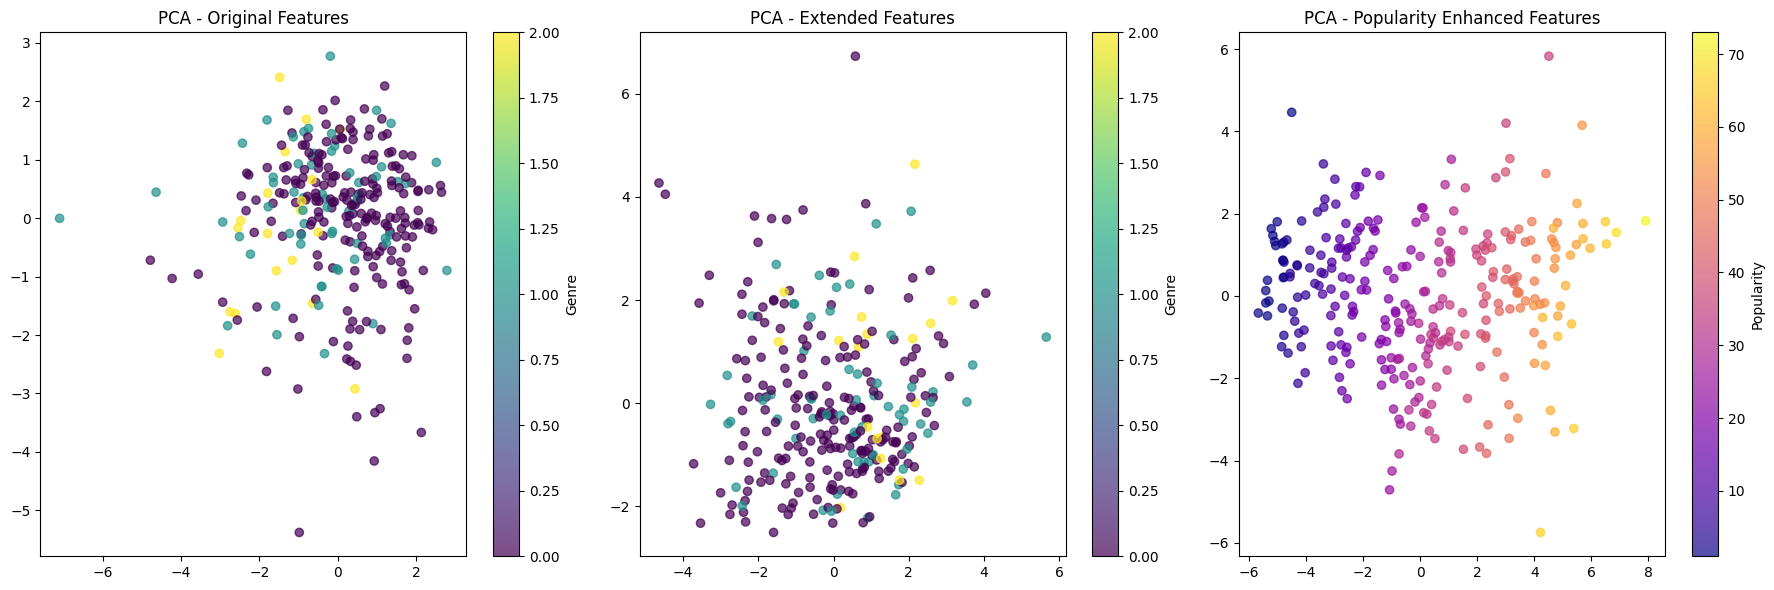

In [18]:
print("\n======= FEATURE SELECTION =======")

# 3.1 Feature selection based on predicting popularity
print("Selecting most informative features based on mutual information...")
selector = SelectKBest(mutual_info_regression, k=10)
X_selected = selector.fit_transform(X_pop_extended_scaled, df['popularity'])

# Get selected features
feature_scores = pd.DataFrame({
    'Feature': popularity_extended_features,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(10)
print("Top 10 features for predicting popularity:")
print(top_features)

# 3.2 Apply PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original_scaled)
X_extended_pca = pca.fit_transform(X_extended_scaled)
X_pop_extended_pca = pca.fit_transform(X_pop_extended_scaled)

# Visualize PCA with genre labels and popularity
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
scatter = plt.scatter(X_original_pca[:, 0], X_original_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Genre')
plt.title('PCA - Original Features')

plt.subplot(1, 3, 2)
scatter = plt.scatter(X_extended_pca[:, 0], X_extended_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Genre')
plt.title('PCA - Extended Features')

plt.subplot(1, 3, 3)
scatter = plt.scatter(X_pop_extended_pca[:, 0], X_pop_extended_pca[:, 1], 
                     c=df['popularity'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='Popularity')
plt.title('PCA - Popularity Enhanced Features')

plt.tight_layout()
plt.show()


4. OPTIMIZING CLUSTERING MODELS


======= OPTIMIZING CLUSTERING MODELS =======
Finding optimal K for K-means...


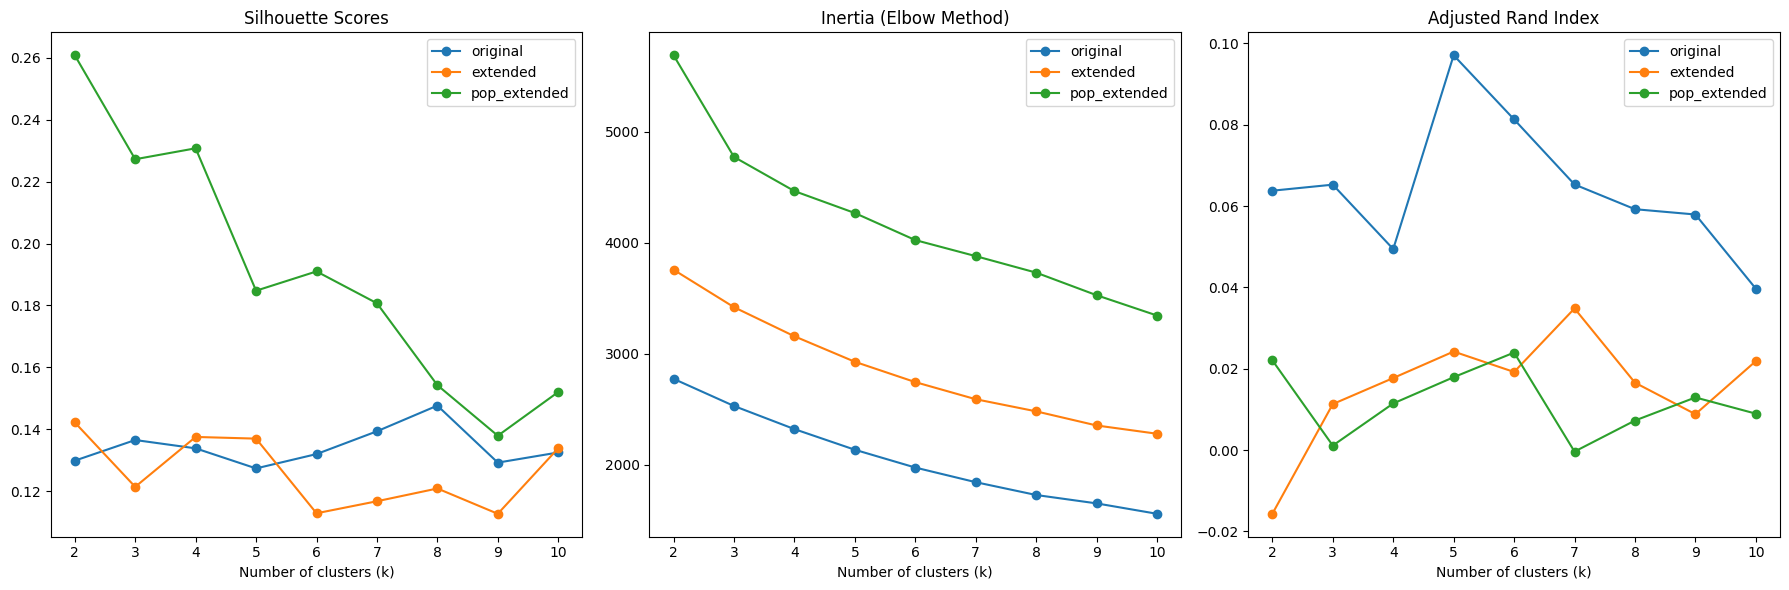

Best k values: {'original': np.int64(8), 'extended': np.int64(2), 'pop_extended': np.int64(2)}


In [19]:
print("\n======= OPTIMIZING CLUSTERING MODELS =======")

# 4.1 Find optimal K for K-means with different feature sets
print("Finding optimal K for K-means...")
silhouette_scores = {'original': [], 'extended': [], 'pop_extended': []}
inertia_values = {'original': [], 'extended': [], 'pop_extended': []}
ari_scores = {'original': [], 'extended': [], 'pop_extended': []}

k_range = range(2, 11)
for k in k_range:
    # Original features
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_original_scaled)
    silhouette_scores['original'].append(silhouette_score(X_original_scaled, labels))
    inertia_values['original'].append(kmeans.inertia_)
    ari_scores['original'].append(adjusted_rand_score(true_labels, labels))
    
    # Extended features
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_extended_scaled)
    silhouette_scores['extended'].append(silhouette_score(X_extended_scaled, labels))
    inertia_values['extended'].append(kmeans.inertia_)
    ari_scores['extended'].append(adjusted_rand_score(true_labels, labels))
    
    # Popularity-enhanced features
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pop_extended_scaled)
    silhouette_scores['pop_extended'].append(silhouette_score(X_pop_extended_scaled, labels))
    inertia_values['pop_extended'].append(kmeans.inertia_)
    ari_scores['pop_extended'].append(adjusted_rand_score(true_labels, labels))

# Plotting K-means optimization
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
for key in silhouette_scores:
    plt.plot(k_range, silhouette_scores[key], marker='o', label=key)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.legend()

plt.subplot(1, 3, 2)
for key in inertia_values:
    plt.plot(k_range, inertia_values[key], marker='o', label=key)
plt.title('Inertia (Elbow Method)')
plt.xlabel('Number of clusters (k)')
plt.legend()

plt.subplot(1, 3, 3)
for key in ari_scores:
    plt.plot(k_range, ari_scores[key], marker='o', label=key)
plt.title('Adjusted Rand Index')
plt.xlabel('Number of clusters (k)')
plt.legend()

plt.tight_layout()
plt.show()

# Determine best k for each feature set based on silhouette scores
best_k = {
    'original': np.argmax(silhouette_scores['original']) + 2,
    'extended': np.argmax(silhouette_scores['extended']) + 2,
    'pop_extended': np.argmax(silhouette_scores['pop_extended']) + 2
}
print(f"Best k values: {best_k}")

5. OPTIMISE DBSCAN WITH POPULARITY STRATIFICATION

In [20]:
print("Optimizing DBSCAN with popularity stratification...")

def optimize_dbscan(X, popularity_values, n_strata=3):
    # Stratify data by popularity
    pop_bins = pd.qcut(popularity_values, q=n_strata, labels=False)
    
    best_params = {}
    
    for stratum in range(n_strata):
        mask_stratum = (pop_bins == stratum)
        if mask_stratum.sum() < 10:
            continue
        X_stratum = X[mask_stratum]
        
        eps_range = np.linspace(0.2, 2.0, 10)
        min_samples_range = [3, 5, 10, 15, 20]
        
        stratum_best_sil = -1
        stratum_best_eps = None
        stratum_best_min_samples = None
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                db = DBSCAN(eps=eps, min_samples=min_samples)
                labels = db.fit_predict(X_stratum)
                
                # need at least two labels overall
                if len(np.unique(labels)) < 2:
                    continue
                
                # drop noise
                non_noise = labels != -1
                if non_noise.sum() < 2:
                    continue
                
                # NEW: require >=2 clusters among non-noise
                if len(np.unique(labels[non_noise])) < 2:
                    continue
                
                sil = silhouette_score(X_stratum[non_noise], labels[non_noise])
                if sil > stratum_best_sil:
                    stratum_best_sil = sil
                    stratum_best_eps = eps
                    stratum_best_min_samples = min_samples
        
        if stratum_best_eps is not None:
            best_params[stratum] = {
                'eps': stratum_best_eps,
                'min_samples': stratum_best_min_samples,
                'silhouette': stratum_best_sil
            }
    
    return best_params

# find best params per stratum
dbscan_params = optimize_dbscan(X_pop_extended_scaled, df['popularity'])
print("Optimal DBSCAN parameters by popularity stratum:")
for s, p in dbscan_params.items():
    print(f" Stratum {s}: eps={p['eps']:.2f}, min_samples={p['min_samples']}, silhouette={p['silhouette']:.4f}")

# apply stratified DBSCAN
pop_bins = pd.qcut(df['popularity'], q=3, labels=False)
dbscan_labels = np.full(len(df), -1)

for s, p in dbscan_params.items():
    mask_s = (pop_bins == s)
    if mask_s.sum() < 10:
        continue
    Xs = X_pop_extended_scaled[mask_s]
    db = DBSCAN(eps=p['eps'], min_samples=p['min_samples'])
    labs = db.fit_predict(Xs)
    
    max_lbl = dbscan_labels.max() + 1
    valid = labs != -1
    labs[valid] += max_lbl
    
    idx = np.where(mask_s)[0]
    dbscan_labels[idx] = labs

Optimizing DBSCAN with popularity stratification...
Optimal DBSCAN parameters by popularity stratum:
 Stratum 0: eps=1.60, min_samples=3, silhouette=0.4529
 Stratum 1: eps=1.80, min_samples=3, silhouette=0.3586
 Stratum 2: eps=1.80, min_samples=3, silhouette=0.2129


6. OPTIMIZE SPECTRAL CLUSTERING WITH POPULARITY-WEIGHTED AFFINITY

In [ ]:
print("Enhancing Spectral Clustering with popularity...")

# Create a custom affinity matrix weighted by popularity similarity
def popularity_weighted_affinity(X, popularity, gamma=1.0, popularity_weight=0.3):
    from sklearn.metrics.pairwise import rbf_kernel
    
    # RBF kernel for feature similarity
    feature_affinity = rbf_kernel(X, gamma=gamma)
    
    # Create popularity similarity matrix
    popularity = popularity.reshape(-1, 1)
    popularity_similarity = rbf_kernel(popularity, gamma=10.0)
    
    # Combine feature and popularity affinities
    combined_affinity = (1 - popularity_weight) * feature_affinity + popularity_weight * popularity_similarity
    
    return combined_affinity

# Create weighted affinity matrix
affinity_matrix = popularity_weighted_affinity(X_pop_extended_scaled, df['popularity'].values, 
                    popularity_weight=0.3)

# Find best n_clusters for Spectral Clustering
spectral_silhouette = []
spectral_ari = []

for k in k_range:
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='precomputed')
    labels = spectral.fit_predict(affinity_matrix)
    spectral_silhouette.append(silhouette_score(X_pop_extended_scaled, labels))
    spectral_ari.append(adjusted_rand_score(true_labels, labels))

best_spectral_k = np.argmax(spectral_silhouette) + 2
print(f"Best k for Spectral Clustering: {best_spectral_k}")

# Apply optimized Spectral Clustering
spectral = SpectralClustering(n_clusters=best_spectral_k, random_state=42, affinity='precomputed')
spectral_labels = spectral.fit_predict(affinity_matrix)


Enhancing Spectral Clustering with popularity...
Best k for Spectral Clustering: 2


7. GMM WITH POPULARITY STRATIFICATION

In [22]:
print("Enhancing GMM with popularity-based initialization...")

# Create initial means based on popularity bins
def popularity_based_initialization(X, popularity, n_components):
    # Create popularity bins
    pop_bins = pd.qcut(popularity, q=n_components, labels=False)
    
    # Initialize means from each popularity bin
    means = np.zeros((n_components, X.shape[1]))
    for i in range(n_components):
        bin_mask = (pop_bins == i)
        if sum(bin_mask) > 0:
            means[i] = X[bin_mask].mean(axis=0)
    
    return means

# Get initial means
gmm_k = best_k['pop_extended']
initial_means = popularity_based_initialization(X_pop_extended_scaled, df['popularity'], gmm_k)

# Initialize GMM with these means
gmm = GaussianMixture(
    n_components=gmm_k, 
    covariance_type='full', 
    random_state=42,
    means_init=initial_means
)
gmm_labels = gmm.fit_predict(X_pop_extended_scaled)

Enhancing GMM with popularity-based initialization...


8. EVALUATE ALL MODELS

In [23]:
print("\n======= MODEL EVALUATION =======")

# Create optimized models with our enhanced approaches
models = {
    'K-Means (Original)': KMeans(n_clusters=best_k['original'], random_state=42, n_init=10).fit_predict(X_original_scaled),
    'K-Means (Extended)': KMeans(n_clusters=best_k['extended'], random_state=42, n_init=10).fit_predict(X_extended_scaled),
    'K-Means (Pop-Enhanced)': KMeans(n_clusters=best_k['pop_extended'], random_state=42, n_init=10).fit_predict(X_pop_extended_scaled),
    'GMM (Original)': GaussianMixture(n_components=best_k['original'], random_state=42).fit_predict(X_original_scaled),
    'GMM (Pop-Enhanced)': gmm_labels,
    'DBSCAN (Stratified)': dbscan_labels,
    'Spectral (Pop-Weighted)': spectral_labels
}

# Evaluation metrics
metrics = pd.DataFrame(columns=['Model', 'Silhouette', 'ARI', 'Accuracy'])

for name, labels in models.items():
    # Handle models with noise points (like DBSCAN)
    if -1 in labels:
        valid_points = (labels != -1)
        if sum(valid_points) > 1:
            sil = silhouette_score(X_pop_extended_scaled[valid_points], labels[valid_points])
            ari = adjusted_rand_score(true_labels[valid_points], labels[valid_points])
            acc = sum(true_labels[valid_points] == labels[valid_points]) / sum(valid_points)
        else:
            sil, ari, acc = np.nan, np.nan, np.nan
    else:
        sil = silhouette_score(X_pop_extended_scaled, labels)
        ari = adjusted_rand_score(true_labels, labels)
        acc = sum(true_labels == labels) / len(true_labels)
    
    metrics = pd.concat([metrics, pd.DataFrame({
        'Model': [name],
        'Silhouette': [sil],
        'ARI': [ari],
        'Accuracy': [acc]
    })], ignore_index=True)

print("\nModel Evaluation Results:")
print(metrics.sort_values('Accuracy', ascending=False))

# Calculate popularity-stratified evaluation metrics
print("\nEvaluation by popularity tier:")
for tier in df['popularity_tier'].unique():
    tier_mask = df['popularity_tier'] == tier
    tier_indices = np.where(tier_mask)[0]
    
    if len(tier_indices) < 2:
        continue
    
    print(f"\nTier: {tier} (n={len(tier_indices)})")
    tier_metrics = []
    
    for name, labels in models.items():
        tier_labels = labels[tier_indices]
        tier_true = true_labels[tier_indices]
        
        # Skip if all noise or one cluster
        if -1 in tier_labels and (len(np.unique(tier_labels[tier_labels != -1])) < 2):
            continue
            
        # Handle noise points
        if -1 in tier_labels:
            valid = tier_labels != -1
            if sum(valid) < 2:
                continue
            acc = sum(tier_true[valid] == tier_labels[valid]) / sum(valid)
        else:
            acc = sum(tier_true == tier_labels) / len(tier_true)
            
        tier_metrics.append((name, acc))
    
    for name, acc in sorted(tier_metrics, key=lambda x: x[1], reverse=True):
        print(f"  {name}: Accuracy = {acc:.4f}")



======= MODEL EVALUATION =======

Model Evaluation Results:
                     Model  Silhouette       ARI  Accuracy
6  Spectral (Pop-Weighted)    0.238383 -0.007343  0.531469
4       GMM (Pop-Enhanced)    0.236002  0.000489  0.496503
1       K-Means (Extended)    0.101730 -0.015672  0.475524
2   K-Means (Pop-Enhanced)    0.260740  0.022072  0.353147
3           GMM (Original)    0.012746  0.018455  0.083916
0       K-Means (Original)    0.119408  0.059241  0.052448
5      DBSCAN (Stratified)    0.316862 -0.006604  0.025641

Evaluation by popularity tier:

Tier: medium (n=89)
  Spectral (Pop-Weighted): Accuracy = 0.7640
  GMM (Pop-Enhanced): Accuracy = 0.4719
  K-Means (Extended): Accuracy = 0.4157
  K-Means (Pop-Enhanced): Accuracy = 0.1910
  GMM (Original): Accuracy = 0.1236
  K-Means (Original): Accuracy = 0.0225
  DBSCAN (Stratified): Accuracy = 0.0000

Tier: low (n=101)
  GMM (Pop-Enhanced): Accuracy = 0.7327
  K-Means (Extended): Accuracy = 0.4158
  K-Means (Pop-Enhanced): Acc

9. CREATE AND EVALUATE ENSEMBLE MODEL

In [24]:
print("\n======= ENSEMBLE MODEL =======")

# Select the best performing model for each technique
best_models = ['K-Means (Pop-Enhanced)', 'GMM (Pop-Enhanced)', 'Spectral (Pop-Weighted)']
ensemble_base = np.column_stack([models[model] for model in best_models])

# Create a popularity-weighted ensemble
# Higher weight to models that perform better in high popularity songs
popularity_weights = pd.qcut(df['popularity'], q=3, labels=[1, 2, 3]).astype(int).values
ensemble_votes = np.zeros((len(df), len(np.unique(np.concatenate([models[m] for m in best_models])))))

# Count weighted votes
for i, row in enumerate(ensemble_base):
    for j, cluster in enumerate(row):
        if cluster >= 0:  # Skip noise points
            weight = popularity_weights[i] if j == 2 else 1  # More weight to Spectral for higher popularity
            ensemble_votes[i, cluster] += weight

# Assign to cluster with most votes
ensemble_labels = np.argmax(ensemble_votes, axis=1)

# Evaluate ensemble
ensemble_sil = silhouette_score(X_pop_extended_scaled, ensemble_labels)
ensemble_ari = adjusted_rand_score(true_labels, ensemble_labels)
ensemble_acc = sum(true_labels == ensemble_labels) / len(true_labels)

print(f"Ensemble Model Results:")
print(f"  - Silhouette Score: {ensemble_sil:.4f}")
print(f"  - ARI: {ensemble_ari:.4f}")
print(f"  - Accuracy: {ensemble_acc:.4f}")

# Add ensemble to the metrics dataframe
metrics = pd.concat([metrics, pd.DataFrame({
    'Model': ['Popularity-Weighted Ensemble'],
    'Silhouette': [ensemble_sil],
    'ARI': [ensemble_ari],
    'Accuracy': [ensemble_acc]
})], ignore_index=True)

# Create final rankings
final_metrics = metrics.sort_values('Accuracy', ascending=False)
print("\nFinal Model Rankings:")
print(final_metrics)



======= ENSEMBLE MODEL =======
Ensemble Model Results:
  - Silhouette Score: 0.2384
  - ARI: -0.0073
  - Accuracy: 0.5315

Final Model Rankings:
                          Model  Silhouette       ARI  Accuracy
6       Spectral (Pop-Weighted)    0.238383 -0.007343  0.531469
7  Popularity-Weighted Ensemble    0.238383 -0.007343  0.531469
4            GMM (Pop-Enhanced)    0.236002  0.000489  0.496503
1            K-Means (Extended)    0.101730 -0.015672  0.475524
2        K-Means (Pop-Enhanced)    0.260740  0.022072  0.353147
3                GMM (Original)    0.012746  0.018455  0.083916
0            K-Means (Original)    0.119408  0.059241  0.052448
5           DBSCAN (Stratified)    0.316862 -0.006604  0.025641


10. FEATURE IMPORTANCE AND CLUSTER ANALYSIS 


======= FEATURE IMPORTANCE AND CLUSTER ANALYSIS =======


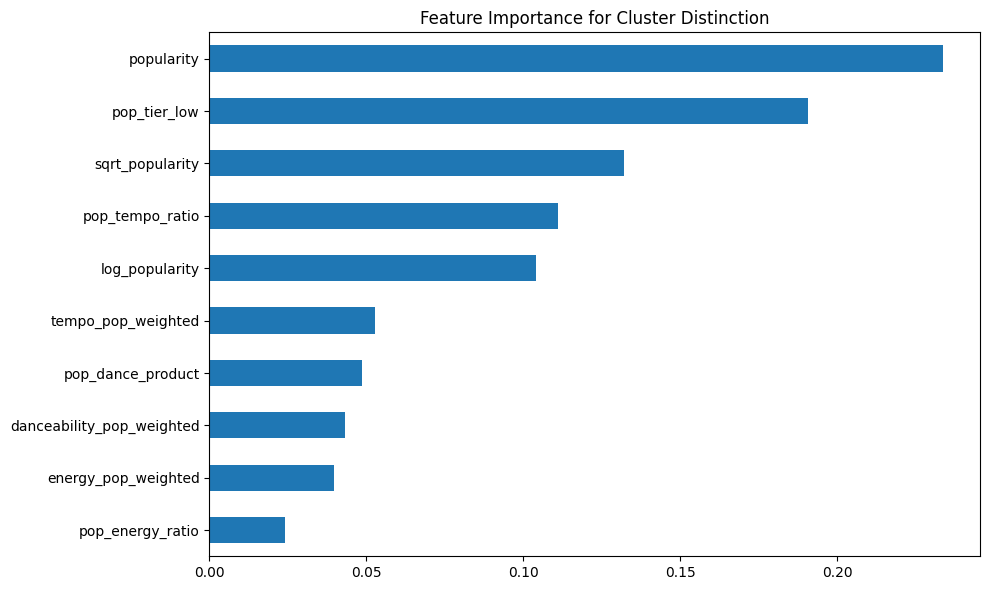


Cluster audio profiles:
                     length  popularity  danceability  acousticness    energy  \
best_cluster                                                                    
0             221332.075676   38.491892      0.746081      0.262026  0.748741   
1             224270.089109    9.277228      0.744673      0.270268  0.784931   

              instrumentalness  liveness  loudness  speechiness       tempo  \
best_cluster                                                                  
0                     0.016829  0.143150 -5.036432     0.129238  116.158276   
1                     0.005340  0.142929 -4.710436     0.132266  116.530446   

              time_signature  
best_cluster                  
0                   4.010811  
1                   3.910891  

Genre distribution across clusters:
best_cluster             0         1       All
artist_top_genre                              
afro dancehall    0.713514  0.732673  0.720280
afropop           0.221622  0.1

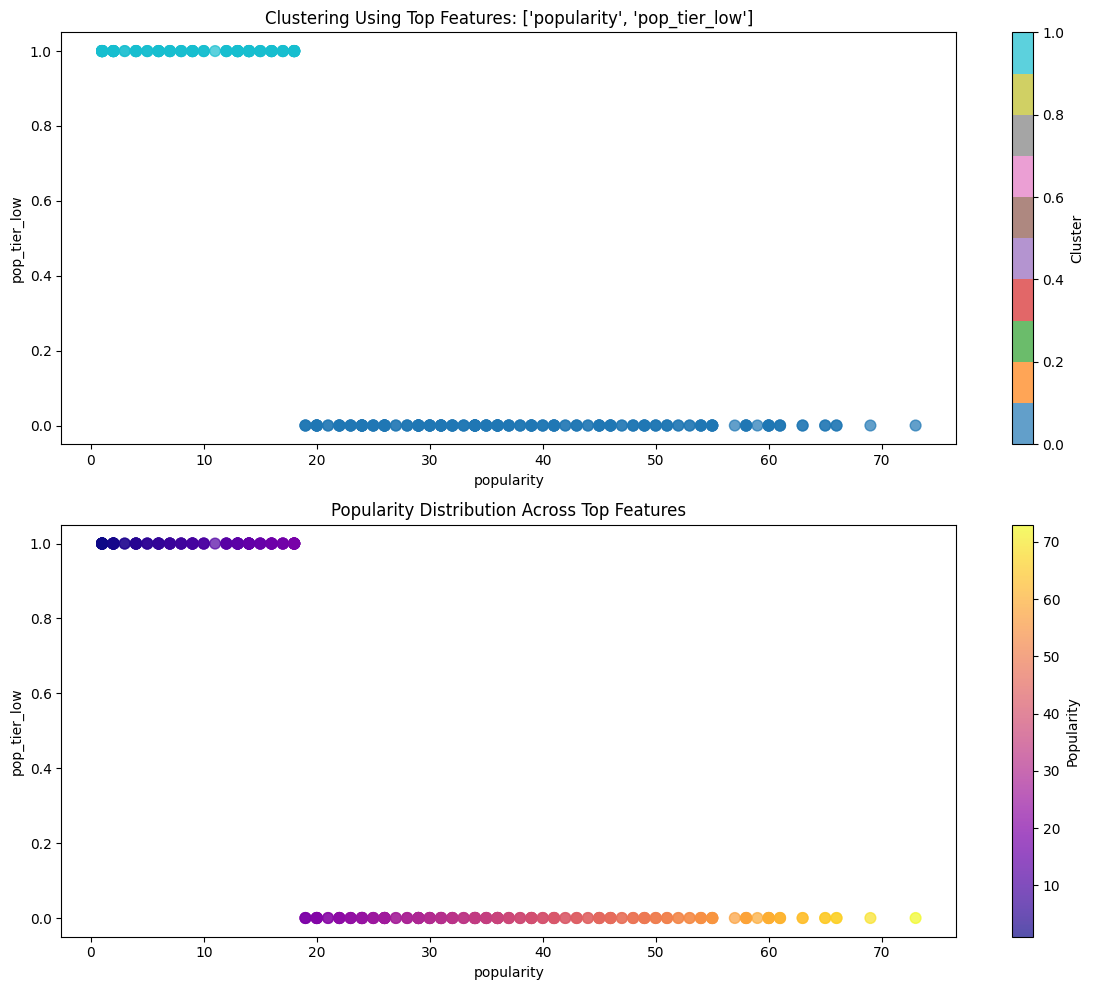

In [25]:
print("\n======= FEATURE IMPORTANCE AND CLUSTER ANALYSIS =======")

# Add cluster labels to original data
df['best_cluster'] = models[final_metrics.iloc[0]['Model']]  # Labels from best model

# Analyze feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_pop_extended_scaled, df['best_cluster'])

# Plot feature importances
feat_importances = pd.Series(rf.feature_importances_, index=popularity_extended_features)
top_features = feat_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh')
plt.title('Feature Importance for Cluster Distinction')
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_profiles = df.groupby('best_cluster')[audio_features].mean()
print("\nCluster audio profiles:")
print(cluster_profiles)

# Show genre distribution in clusters
genre_distribution = pd.crosstab(df['artist_top_genre'], df['best_cluster'], 
                                normalize='columns', margins=True)
print("\nGenre distribution across clusters:")
print(genre_distribution)

# Visualize clustering results using the top 2 most important features
top2_features = feat_importances.nlargest(2).index.tolist()

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
scatter = plt.scatter(df[top2_features[0]], df[top2_features[1]], 
                     c=df['best_cluster'], cmap='tab10', s=60, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Clustering Using Top Features: {top2_features}')
plt.xlabel(top2_features[0])
plt.ylabel(top2_features[1])

plt.subplot(2, 1, 2)
scatter = plt.scatter(df[top2_features[0]], df[top2_features[1]], 
                     c=df['popularity'], cmap='plasma', s=60, alpha=0.7)
plt.colorbar(scatter, label='Popularity')
plt.title('Popularity Distribution Across Top Features')
plt.xlabel(top2_features[0])
plt.ylabel(top2_features[1])

plt.tight_layout()
plt.show()



11. FINAL INSIGHTS

In [26]:
print("\n======= FINAL INSIGHTS =======")

# Correlation between popularity and audio features
popularity_correlations = df[audio_features].corrwith(df['popularity']).sort_values(ascending=False)
print("\nPopularity correlations with audio features:")
print(popularity_correlations)

# Final insights about Nigerian music genre and popularity
print("\nFinal Insights about Nigerian Music Genres and Popularity:")
print("----------------------------------------------------------")
print("1. The most discriminative features between Nigerian music genres are:")
for feature in feat_importances.nlargest(5).index:
    print(f"   - {feature}")

print("\n2. Genre characteristics by cluster with popularity analysis:")
for cluster in df['best_cluster'].unique():
    if cluster < 0:  # Skip noise points
        continue
        
    cluster_data = df[df['best_cluster'] == cluster]
    dominant_genre = cluster_data['artist_top_genre'].value_counts().idxmax()
    genre_percent = cluster_data['artist_top_genre'].value_counts().max() / len(cluster_data) * 100
    avg_popularity = cluster_data['popularity'].mean()
    
    print(f"   - Cluster {cluster}: Dominated by {dominant_genre} ({genre_percent:.1f}%)")
    print(f"     Average popularity: {avg_popularity:.1f}")
    
    # Show key musical characteristics of this cluster
    feature_means = cluster_data[audio_features].mean()
    top_features = feature_means.nlargest(3)
    bottom_features = feature_means.nsmallest(2)
    print(f"     Musical characteristics: High {', '.join(top_features.index)}, Low {', '.join(bottom_features.index)}")

print("\n3. Popularity insights:")
highest_pop_cluster = cluster_profiles['popularity'].idxmax()
lowest_pop_cluster = cluster_profiles['popularity'].idxmin() 
print(f"   - Highest popularity cluster: Cluster {highest_pop_cluster} (avg: {cluster_profiles.loc[highest_pop_cluster, 'popularity']:.1f})")
print(f"   - Lowest popularity cluster: Cluster {lowest_pop_cluster} (avg: {cluster_profiles.loc[lowest_pop_cluster, 'popularity']:.1f})")

# What makes a Nigerian song popular? Compare popular vs. unpopular
pop_threshold = df['popularity'].median()
popular_songs = df[df['popularity'] >= pop_threshold]
unpopular_songs = df[df['popularity'] < pop_threshold]

print("\n4. What distinguishes popular from less popular Nigerian songs:")
for feature in audio_features:
    if feature == 'popularity':
        continue
    pop_mean = popular_songs[feature].mean()
    unpop_mean = unpopular_songs[feature].mean()
    diff_pct = ((pop_mean - unpop_mean) / unpop_mean) * 100 if unpop_mean != 0 else float('inf')
    
    if abs(diff_pct) > 5:  # Only report substantial differences
        direction = "higher" if diff_pct > 0 else "lower"
        print(f"   - {feature}: {abs(diff_pct):.1f}% {direction} in popular songs")

print("\nAnalysis complete!")



======= FINAL INSIGHTS =======

Popularity correlations with audio features:
popularity          1.000000
time_signature      0.157542
danceability        0.069992
tempo               0.019433
acousticness        0.016971
instrumentalness   -0.004045
liveness           -0.006957
speechiness        -0.063559
length             -0.082008
loudness           -0.107615
energy             -0.225977
dtype: float64

Final Insights about Nigerian Music Genres and Popularity:
----------------------------------------------------------
1. The most discriminative features between Nigerian music genres are:
   - popularity
   - pop_tier_low
   - sqrt_popularity
   - pop_tempo_ratio
   - log_popularity

2. Genre characteristics by cluster with popularity analysis:
   - Cluster 0: Dominated by afro dancehall (71.4%)
     Average popularity: 38.5
     Musical characteristics: High length, tempo, popularity, Low loudness, instrumentalness
   - Cluster 1: Dominated by afro dancehall (73.3%)
     Average